# Precipitation

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid
from ml_downscaling_emulator.preprocessing.select_domain import SelectDomain

## MOOSE CPM Precip
### lsrain

In [2]:
ds_meta = UKCPDatasetMetadata(os.getenv("MOOSE_DATA"), variable="lsrain", domain="uk", frequency="day", resolution="2.2km")

ds = xr.open_dataset(ds_meta.filepath(1981))

ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 654,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float32 -5.547 -5.511 ... 8.927
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] ...
    forecast_reference_time     object ...
    realization                 int32 ...
Dimensions without coordinates: bnds
Data variables:
    stratiform_rainfall_flux    (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (grid_longitude, bnds) float32 ...
    forecast_period_bnds        (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [3]:
ds["grid_latitude_bnds"]

<xarray.DataArray 'grid_latitude_bnds' (grid_latitude: 654, bnds: 2)>
array([[-5.564749, -5.528749],
       [-5.528749, -5.492749],
       [-5.492749, -5.456749],
       ...,
       [ 8.836849,  8.872849],
       [ 8.872849,  8.908849],
       [ 8.908849,  8.944849]], dtype=float32)
Coordinates:
  * grid_latitude            (grid_latitude) float32 -5.547 -5.511 ... 8.927
    forecast_reference_time  object 1979-09-01 00:00:00
    realization              int32 1100000
Dimensions without coordinates: bnds

## Mean precip

In [4]:
uk_mon_pr_ds = xr.open_mfdataset("/home/henry/cdt/summer/data/ceda/uk/2.2km/rcp85/01/pr/mon/*.nc")
uk_mon_pr_ds

<xarray.Dataset>
Dimensions:                     (ensemble_member: 1, time: 720,
                                 grid_latitude: 606, grid_longitude: 484,
                                 bnds: 2)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-16 00:00:00 ... 2080-11...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude                    (grid_latitude, grid_longitude) float64 dask.array<chunksize=(606, 484), meta=np.ndarray>
    longitude                   (grid_latitude, grid_longitude) float64 dask.array<chunksize=(606, 484), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    yyyymm                      (time) |S64 dask.array<chunksize=(12,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                          (ensemble_member, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 12, 606, 484), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    grid_latitude_bnds          (time, grid_latitude, bnds) float64 dask.array<chunksize=(12, 606, 2), meta=np.ndarray>
    grid_longitude_bnds         (time, grid_longitude, bnds) float64 dask.array<chunksize=(12, 484, 2), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2021-05-12T10:56:42
    domain:          uk
    frequency:       mon
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20210615
    Conventions:     CF-1.7

In [3]:
uk_pr_mean_da = uk_mon_pr_ds["pr"].isel(ensemble_member=0).mean(dim="time")
london_pr_mean_da = SelectDomain(subdomain="london").run(uk_pr_mean_da).isel(grid_latitude=slice(32), grid_longitude=slice(32))

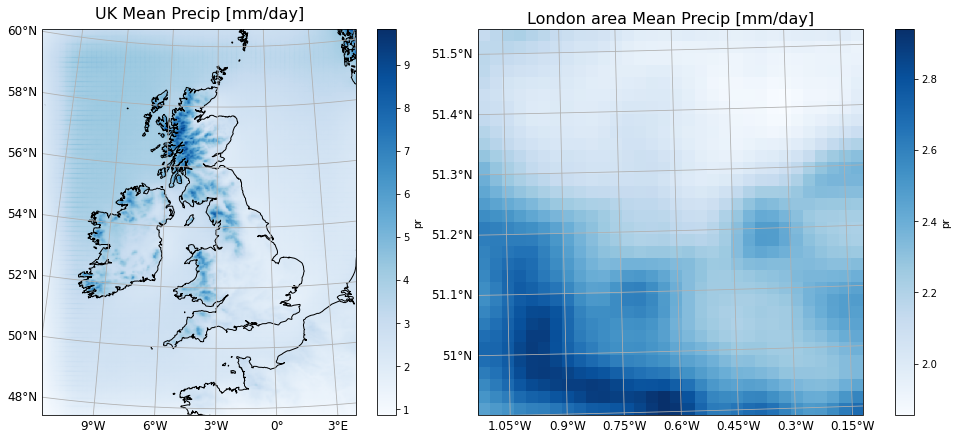

In [4]:
fig, axd = plt.subplot_mosaic([["uk", "london"]], figsize=(14, 6), subplot_kw={'projection': cp_model_rotated_pole}, constrained_layout=True)

ax = axd["uk"]
plot_grid(uk_pr_mean_da, ax=ax, title="UK Mean Precip [mm/day]", transform=cp_model_rotated_pole, cmap="Blues", norm=None, add_colorbar=True)

ax = axd["london"]
plot_grid(london_pr_mean_da, ax=ax, title="London area Mean Precip [mm/day]", transform=cp_model_rotated_pole, cmap="Blues", norm=None, add_colorbar=True)

plt.show()

## Compare training set properties

In [5]:
dataset_name = "2.2km-coarsened-8x_london_vorticity850_random"
train_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, "train.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))
val_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, "val.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))

val_ds["target_pr"] = (val_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})
train_ds["target_pr"] = (train_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})

train_pr_mean_da = train_ds["target_pr"].mean(dim="time")
val_pr_mean_da = val_ds["target_pr"].mean(dim="time")

### Means

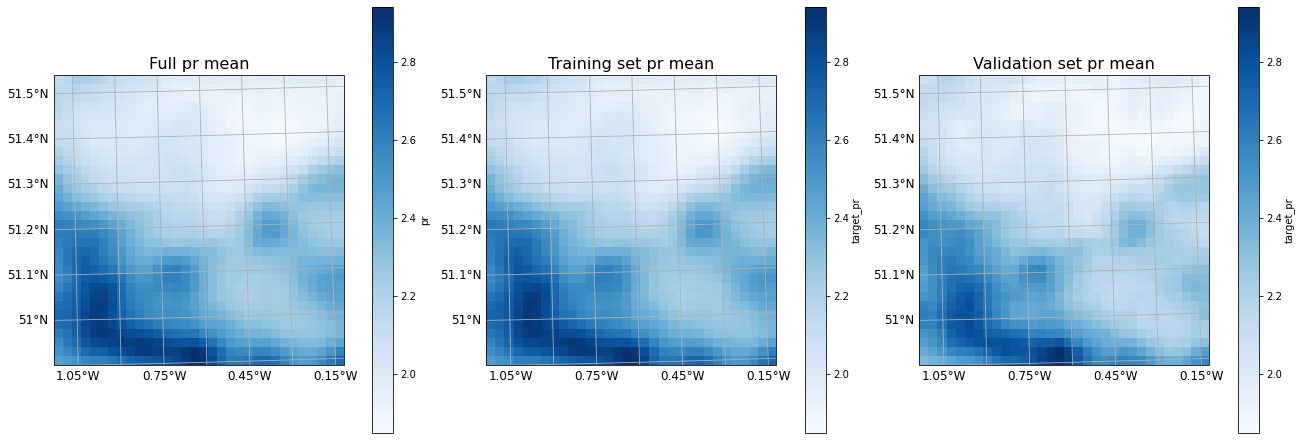

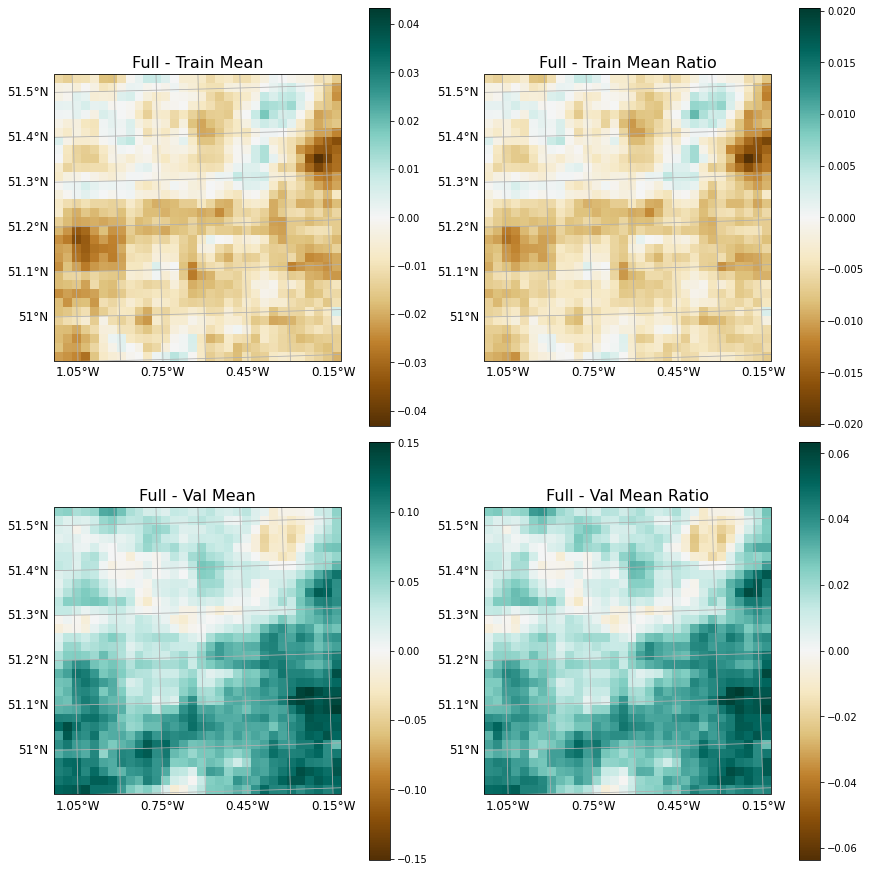

In [8]:
fig, axd = plt.subplot_mosaic([["Full", "Train", "Val"]], figsize=(18, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

vmin = min([da.min().values for da in [train_pr_mean_da, val_pr_mean_da, london_pr_mean_da]])
vmax = max([da.max().values for da in [train_pr_mean_da, val_pr_mean_da, london_pr_mean_da]])

ax = axd["Full"]
plot_grid(london_pr_mean_da, ax, title="Full pr mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True)

ax = axd["Train"]
plot_grid(train_pr_mean_da, ax, title="Training set pr mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True)

ax = axd["Val"]
plot_grid(val_pr_mean_da, ax, title="Validation set pr mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True)

plt.show()

fig, axd = plt.subplot_mosaic([["Full - Train Mean", "Full - Train Mean Ratio"], ["Full - Val Mean", "Full - Val Mean Ratio"]], figsize=(12, 12), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Full - Train Mean"]
plot_grid((london_pr_mean_da - train_pr_mean_da), ax, title="Full - Train Mean", norm=None, add_colorbar=True, cmap='BrBG', center=0)

ax = axd["Full - Train Mean Ratio"]
plot_grid(((london_pr_mean_da - train_pr_mean_da)/london_pr_mean_da), ax, title="Full - Train Mean Ratio", norm=None, add_colorbar=True, cmap='BrBG', center=0)

ax = axd["Full - Val Mean"]
plot_grid((london_pr_mean_da - val_pr_mean_da), ax, title="Full - Val Mean", norm=None, add_colorbar=True, cmap='BrBG', center=0)

ax = axd["Full - Val Mean Ratio"]
plot_grid(((london_pr_mean_da - val_pr_mean_da)/london_pr_mean_da), ax, title="Full - Val Mean Ratio", norm=None, add_colorbar=True, cmap='BrBG', center=0)

plt.show()